# Baseline Random Forest Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as random

from tqdm import tqdm

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
features = ['x_mean', 'y_mean', 'z_mean', 'mag_mean', 'x_std', 'y_std', 'z_std', 'mag_std', 
                'x_median', 'y_median', 'z_median', 'mag_median', 'x_crossing', 'y_crossing', 'z_crossing', 
                'x_max', 'y_max', 'z_max', 'mag_max', 'time_entropy', 'frequency_entropy', 'spectral_centroid',
                'spectral_spread', 'spectral_flux', 'spectral_rolloff']

In [4]:
features_df = pd.read_parquet("balanced_features.parquet")

features_df

,time,pid,x_mean,y_mean,z_mean,mag_mean,x_std,y_std,z_std,mag_std,...,y_max,z_max,mag_max,time_entropy,frequency_entropy,spectral_centroid,spectral_spread,spectral_flux,spectral_rolloff,TAC_class
0,2017-05-02 14:04:40,SA0297,-0.222442,-0.075598,-0.015889,0.242998,6.988053e-02,3.550172e-02,7.062066e-03,5.092628e-02,...,0.0861,0.0849,0.293697,6.161106e-01,0.025375,3.205993e+04,9.724189e+08,1.265986e+04,392,0.0
0,2017-05-02 14:04:44,SA0297,0.009088,-0.042815,-0.008202,0.073136,3.185934e-02,5.166347e-02,2.756228e-02,3.283147e-02,...,0.1881,0.1161,0.227391,2.089842e+00,0.049024,-1.743570e+04,3.120597e+08,1.920136e+03,987,0.0
0,2017-05-02 14:04:48,SA0297,0.000233,0.000279,-0.012446,0.056119,2.208625e-02,1.088092e-02,5.806136e-02,3.135288e-02,...,0.0324,0.1393,0.146422,2.926396e+00,0.247524,8.175000e+02,5.876386e+05,1.740432e+03,990,0.0
0,2017-05-02 14:04:52,SA0297,0.015000,0.012800,-0.025800,0.032473,6.938894e-18,3.469447e-18,6.938894e-18,6.938894e-18,...,0.0128,0.0258,0.032473,-1.442695e-10,0.011408,3.105155e-13,1.286114e-10,4.000000e+00,0,0.0
0,2017-05-02 14:04:56,SA0297,0.028955,0.019178,-0.011516,0.118029,1.039950e-01,5.769088e-02,1.421302e-01,1.474860e-01,...,0.2176,0.7028,0.715980,1.300715e+00,0.308401,-1.730865e+04,-7.448975e+06,3.402120e+03,991,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2017-05-02 22:58:24,DK3500,-0.282059,0.812773,0.919243,1.494816,5.524381e-01,7.710623e-01,4.508139e-01,6.735337e-01,...,3.6328,2.8105,4.068333,2.195081e+00,0.011408,1.963719e+05,3.852014e+10,2.606618e+06,973,0.0
0,2017-05-02 22:58:28,DK3500,-0.398836,0.841703,0.873992,1.500703,5.797443e-01,6.457703e-01,4.180652e-01,5.542438e-01,...,2.2785,2.4691,3.493737,2.831896e+00,0.011408,-1.217293e+05,1.479031e+10,1.813968e+06,985,0.0
0,2017-05-02 22:58:32,DK3500,-0.395525,0.851949,0.918978,1.517392,5.291713e-01,6.721786e-01,4.653721e-01,6.105056e-01,...,3.0226,2.8839,3.568501,2.319288e+00,0.011408,-9.660115e+04,9.315850e+09,2.201106e+06,975,0.0
0,2017-05-02 22:58:36,DK3500,-0.445867,0.862403,0.879934,1.460645,4.950609e-01,5.739813e-01,3.984550e-01,5.627110e-01,...,1.9277,2.4865,3.384682,2.608129e+00,0.011408,-6.160347e+05,3.677053e+11,1.677647e+06,981,0.0


In [5]:
pids = ['SA0297','PC6771','BK7610','DC6359','MC7070','MJ8002','BU4707','JR8022','HV0618','SF3079','JB3156','CC6740','DK3500']

## Initial Model Testing

In [6]:
test_pid = 'MC7070'

df_train = features_df.loc[features_df['pid'] != test_pid]
df_test = features_df.loc[features_df['pid'] == test_pid]

In [7]:
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train[['TAC_class']]
y_test = df_test[['TAC_class']]

In [8]:
# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

/var/folders/kk/v1dq6w817kb25skcwjv3tgyw0000gn/T/ipykernel_76117/4052469552.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Accuracy: 0.903879666146932


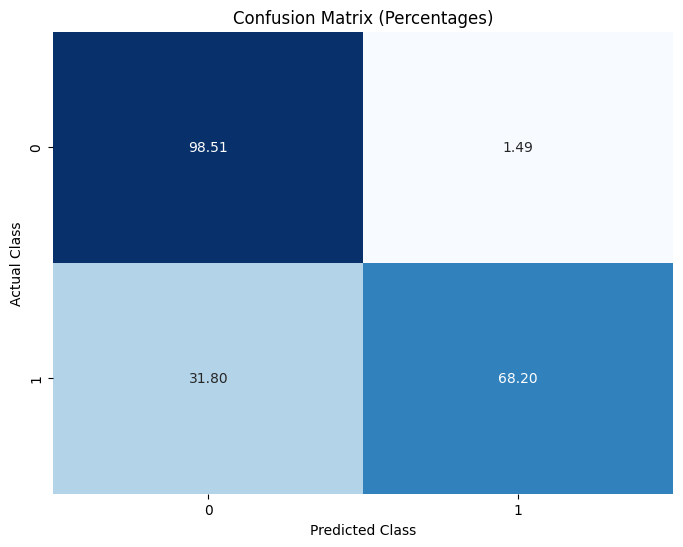

In [9]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Percentages)")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

## K-Folds Training

In [10]:
def k_folds_by_person(pids):
    # Creates 13-fold training set, setting aside 1 person each fold for validation

    kfold_iterations = []
    for i in range(len(pids) - 1):
        kfold_iterations.append((pids[i], pids[:i] + pids[i + 1:]))
    kfold_iterations.append((pids[-1], pids[:-1]))

    return kfold_iterations

In [33]:
def train_on_k_folds(features, df, kfold_iterations):
    accuracies = []
    confusion_matrices_raw = []
    confusion_matrices_norm = []
    test_pids = []
    models = []

    iteration = 1
    for test_pid, _ in kfold_iterations:
        df_train = df.loc[df['pid'] != test_pid]
        df_test = df.loc[df['pid'] == test_pid]
        
        X_train = df_train[features]
        X_test = df_test[features]
        y_train = df_train[['TAC_class']]
        y_test = df_test[['TAC_class']]
        
        # Initialize and train the classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train, y_train.values.ravel())
        y_pred = rf_classifier.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
        confusion_matrices_raw.append(conf_matrix)
        confusion_matrices_norm.append(conf_matrix_norm)

        test_pids.append(test_pid)
        models.append(rf_classifier)

        print(f"Iteration #{iteration} (test on {test_pid}): {round(accuracy, 4) * 100}% accuracy")
        iteration += 1
    
    return test_pids, accuracies, confusion_matrices_raw, confusion_matrices_norm, models

In [34]:
def plot_confusion_matrices(test_pids, accuracies, confusion_matrices):

    for i in range(len(test_pids)):
        test_pid = test_pids[i]
        accuracy = accuracies[i]
        conf_matrix = confusion_matrices[i]

        plt.figure(figsize=(8, 6))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
        plt.title(f"Iteration #{i+1} (test on {test_pid}): {round(accuracy * 100, 2)}% accuracy")
        plt.colorbar()

        classes = ['Sober', 'Drunk']  # Adjust these according to your actual classes
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        thresh = conf_matrix.max() / 2.
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                plt.text(j, i, format(conf_matrix[i, j], '.2f') + "%",
                         ha="center", va="center",
                         color="white" if conf_matrix[i, j] > thresh else "black")

        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.show()

In [35]:
kfolds = k_folds_by_person(pids)

kfolds

[('SA0297',
  ['PC6771',
   'BK7610',
   'DC6359',
   'MC7070',
   'MJ8002',
   'BU4707',
   'JR8022',
   'HV0618',
   'SF3079',
   'JB3156',
   'CC6740',
   'DK3500']),
 ('PC6771',
  ['SA0297',
   'BK7610',
   'DC6359',
   'MC7070',
   'MJ8002',
   'BU4707',
   'JR8022',
   'HV0618',
   'SF3079',
   'JB3156',
   'CC6740',
   'DK3500']),
 ('BK7610',
  ['SA0297',
   'PC6771',
   'DC6359',
   'MC7070',
   'MJ8002',
   'BU4707',
   'JR8022',
   'HV0618',
   'SF3079',
   'JB3156',
   'CC6740',
   'DK3500']),
 ('DC6359',
  ['SA0297',
   'PC6771',
   'BK7610',
   'MC7070',
   'MJ8002',
   'BU4707',
   'JR8022',
   'HV0618',
   'SF3079',
   'JB3156',
   'CC6740',
   'DK3500']),
 ('MC7070',
  ['SA0297',
   'PC6771',
   'BK7610',
   'DC6359',
   'MJ8002',
   'BU4707',
   'JR8022',
   'HV0618',
   'SF3079',
   'JB3156',
   'CC6740',
   'DK3500']),
 ('MJ8002',
  ['SA0297',
   'PC6771',
   'BK7610',
   'DC6359',
   'MC7070',
   'BU4707',
   'JR8022',
   'HV0618',
   'SF3079',
   'JB3156',
   'CC67

In [36]:
test_pids, accuracies, confusion_matrices_raw, confusion_matrices_norm, models = train_on_k_folds(features, features_df, kfolds)

Iteration #1 (test on SA0297): 73.24000000000001% accuracy
Iteration #2 (test on PC6771): 43.78% accuracy
Iteration #3 (test on BK7610): 68.78% accuracy
Iteration #4 (test on DC6359): 59.96% accuracy
Iteration #5 (test on MC7070): 90.39% accuracy
Iteration #6 (test on MJ8002): 64.96% accuracy
Iteration #7 (test on BU4707): 85.19% accuracy
Iteration #8 (test on JR8022): 68.11% accuracy
Iteration #9 (test on HV0618): 87.18% accuracy
Iteration #10 (test on SF3079): 83.32000000000001% accuracy
Iteration #11 (test on JB3156): 50.980000000000004% accuracy
Iteration #12 (test on CC6740): 60.29% accuracy
Iteration #13 (test on DK3500): 13.209999999999999% accuracy


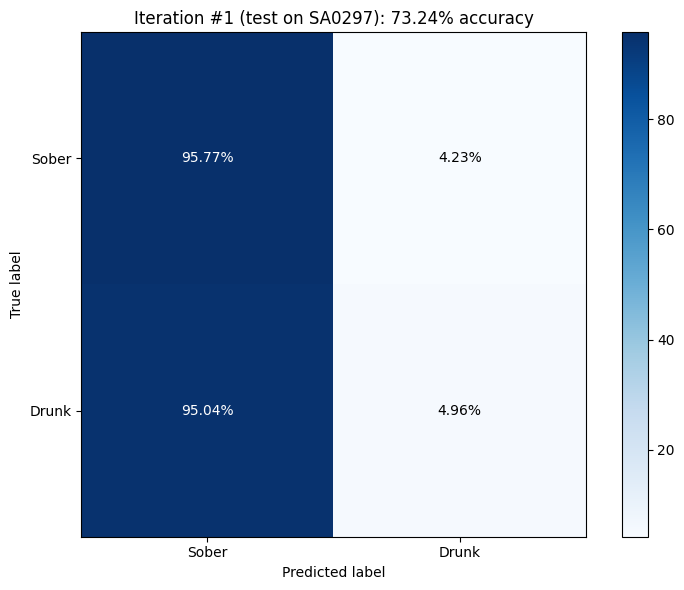

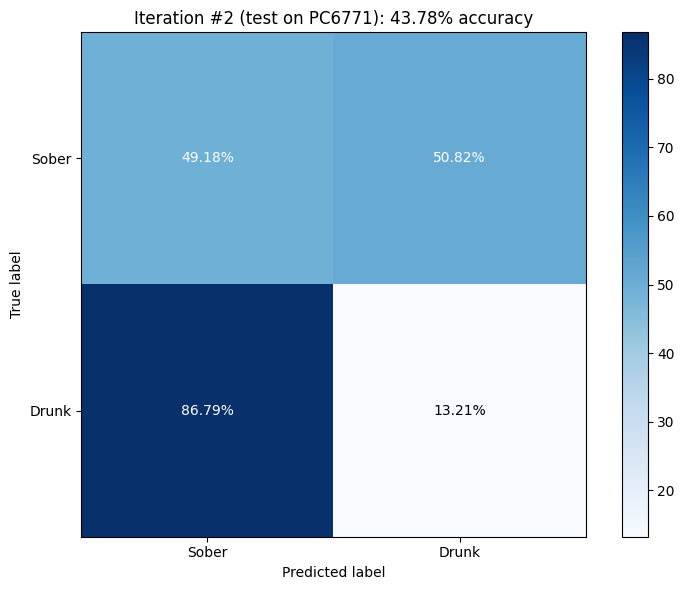

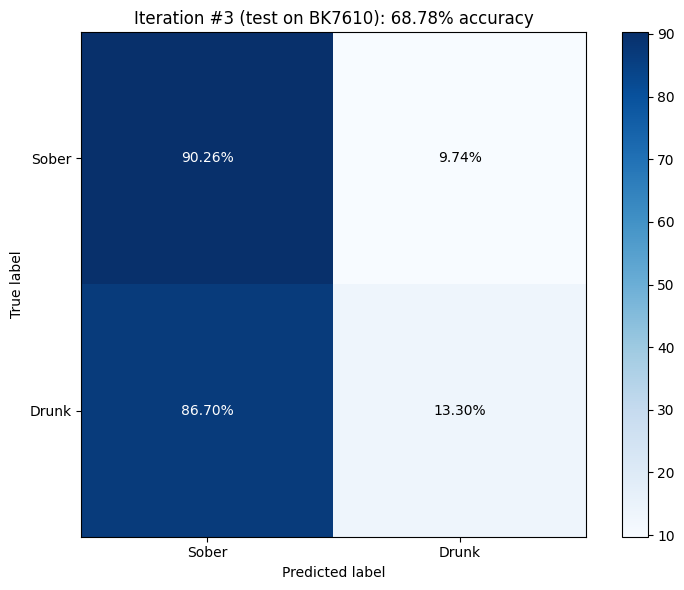

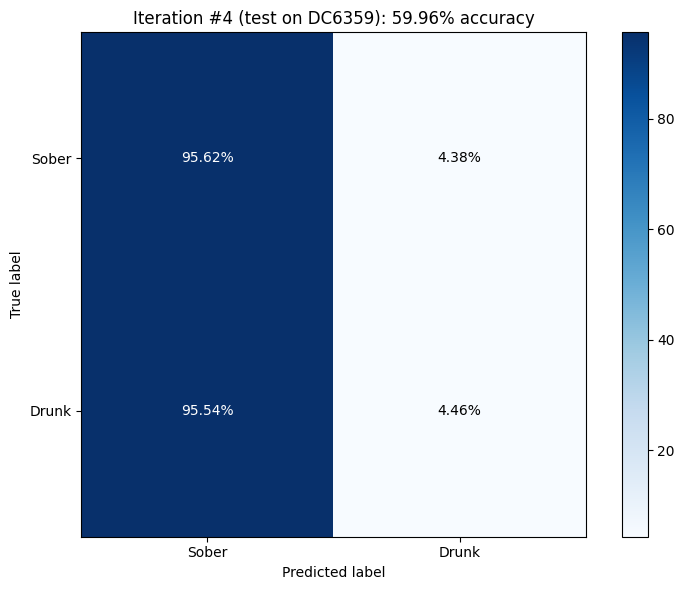

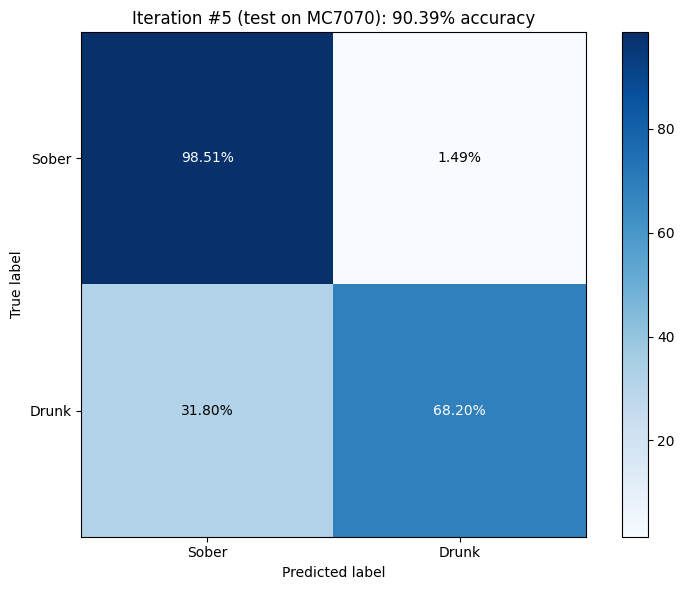

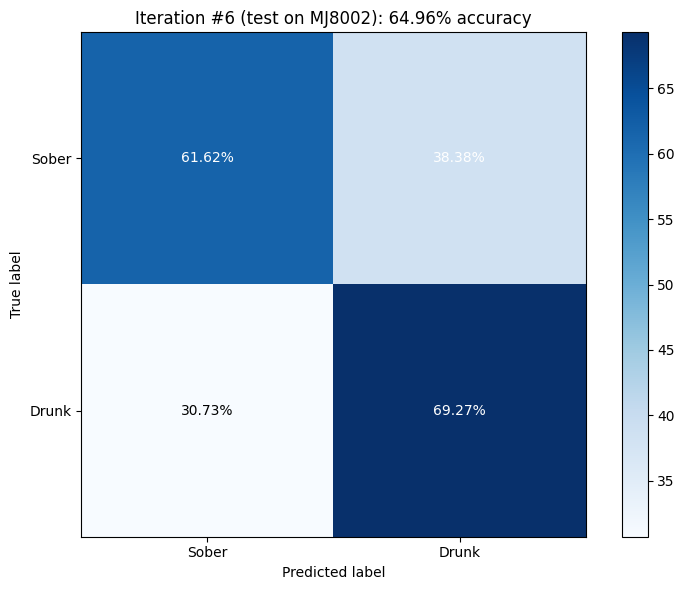

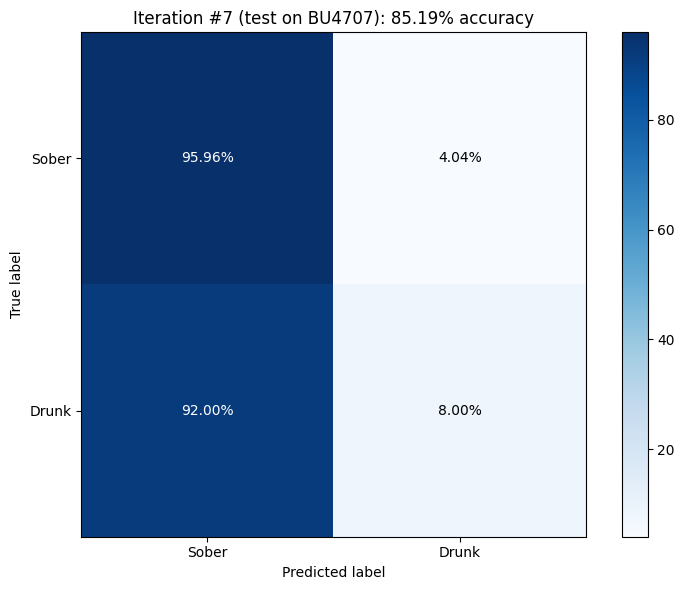

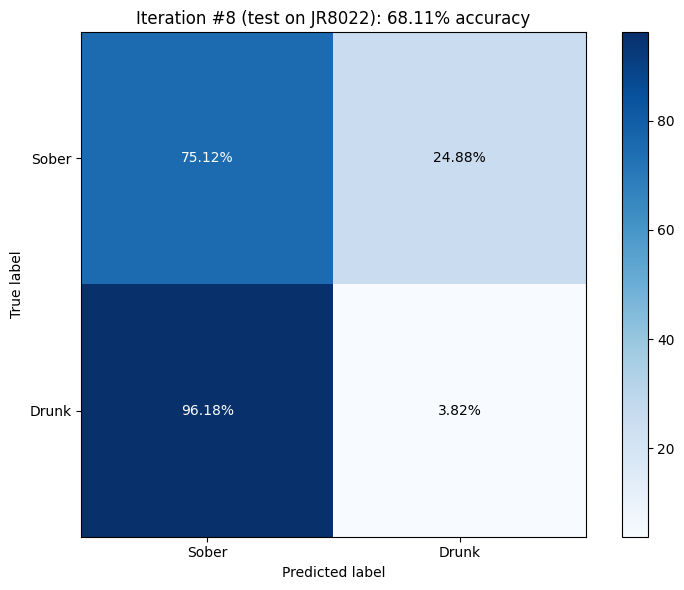

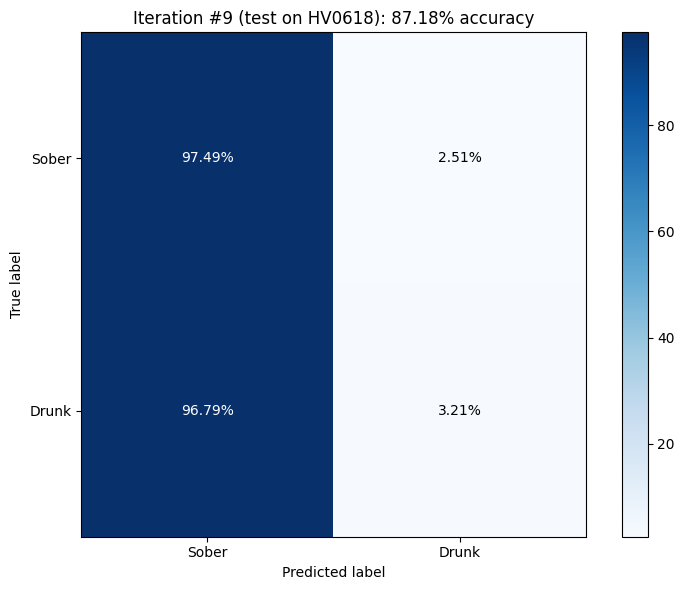

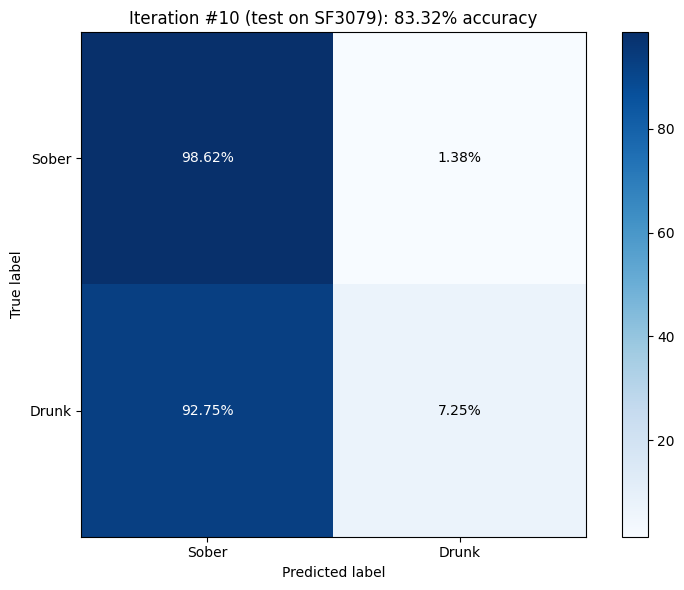

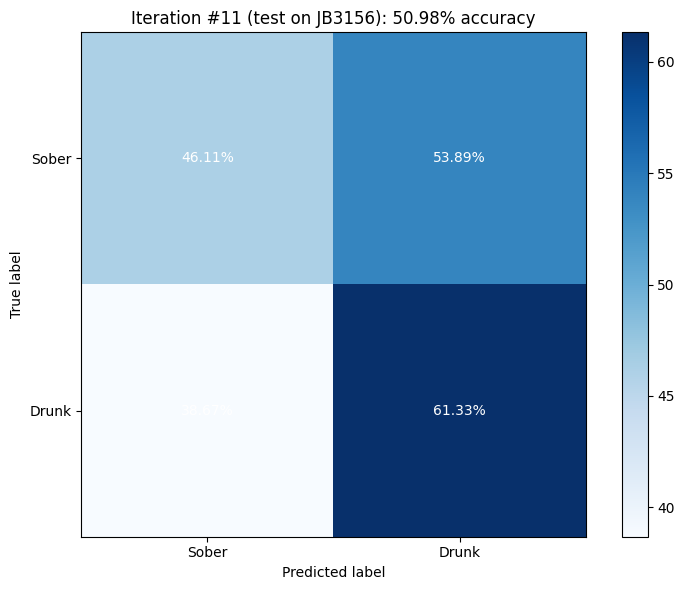

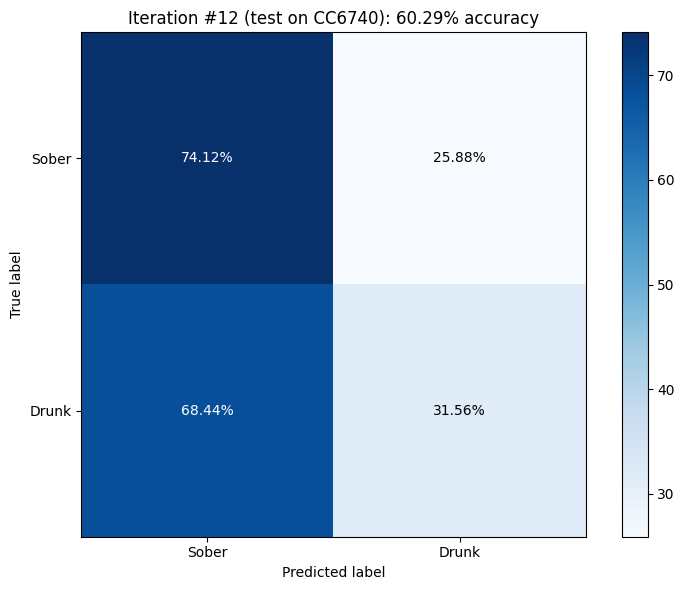

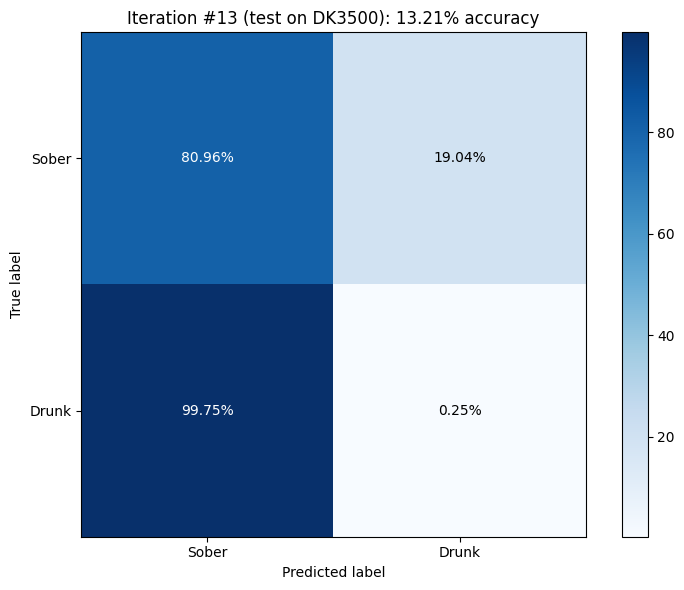

In [37]:
plot_confusion_matrices(test_pids, accuracies, confusion_matrices_norm)

In [38]:
# saving the confusion matrix data
cm_data = []
for idx, pid in enumerate(test_pids):
    cm_norm = confusion_matrices_norm[idx]
    cm = confusion_matrices_raw[idx]
    cm_data.append((pid, cm_norm[0][0], cm_norm[0][1], cm_norm[1][1], cm_norm[1][0], cm[0][0], cm[0][1], cm[1][1], cm[1][0]))


cm_data

[('SA0297',
  95.76901086335049,
  4.230989136649514,
  4.956672443674177,
  95.04332755632582,
  8375,
  370,
  143,
  2742),
 ('PC6771',
  49.18344094189138,
  50.81655905810862,
  13.211600429645543,
  86.78839957035446,
  2590,
  2676,
  123,
  808),
 ('BK7610',
  90.25917550878414,
  9.740824491215863,
  13.2973944294699,
  86.7026055705301,
  5189,
  560,
  296,
  1930),
 ('DC6359',
  95.62411776567856,
  4.375882234321436,
  4.45699937225361,
  95.5430006277464,
  4742,
  217,
  142,
  3044),
 ('MC7070',
  98.50914557754949,
  1.4908544224505136,
  68.19582334816843,
  31.80417665183157,
  7863,
  119,
  1992,
  929),
 ('MJ8002',
  61.621378845721985,
  38.378621154278015,
  69.26857473258167,
  30.731425267418327,
  2744,
  1709,
  2396,
  1063),
 ('BU4707',
  95.95982142857142,
  4.040178571428572,
  8.0,
  92.0,
  4299,
  181,
  50,
  575),
 ('JR8022',
  75.11712649661635,
  24.882873503383653,
  3.8186157517899764,
  96.18138424821002,
  5772,
  1912,
  32,
  806),
 ('HV0618

In [39]:
columns = ['pid', 'sober_correct', 'sober_incorrect', 'drunk_correct', 'drunk_incorrect', 'sober_correct_raw', 'sober_incorrect_raw', 'drunk_correct_raw', 'drunk_incorrect_raw']

cm_df = pd.DataFrame(cm_data, columns=columns)

cm_df

,pid,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,sober_correct_raw,sober_incorrect_raw,drunk_correct_raw,drunk_incorrect_raw
0,SA0297,95.769011,4.230989,4.956672,95.043328,8375,370,143,2742
1,PC6771,49.183441,50.816559,13.211600,86.788400,2590,2676,123,808
2,BK7610,90.259176,9.740824,13.297394,86.702606,5189,560,296,1930
3,DC6359,95.624118,4.375882,4.456999,95.543001,4742,217,142,3044
4,MC7070,98.509146,1.490854,68.195823,31.804177,7863,119,1992,929
5,MJ8002,61.621379,38.378621,69.268575,30.731425,2744,1709,2396,1063
6,BU4707,95.959821,4.040179,8.000000,92.000000,4299,181,50,575
7,JR8022,75.117126,24.882874,3.818616,96.181384,5772,1912,32,806
8,HV0618,97.491793,2.508207,3.208556,96.791444,7424,191,30,905
9,SF3079,98.624067,1.375933,7.246377,92.753623,8458,118,125,1600


In [40]:
cm_df.to_parquet("baseline_cm_data.parquet")

In [41]:
cm_df = pd.read_parquet("baseline_cm_data.parquet")

cm_df

,pid,sober_correct,sober_incorrect,drunk_correct,drunk_incorrect,sober_correct_raw,sober_incorrect_raw,drunk_correct_raw,drunk_incorrect_raw
0,SA0297,95.769011,4.230989,4.956672,95.043328,8375,370,143,2742
1,PC6771,49.183441,50.816559,13.211600,86.788400,2590,2676,123,808
2,BK7610,90.259176,9.740824,13.297394,86.702606,5189,560,296,1930
3,DC6359,95.624118,4.375882,4.456999,95.543001,4742,217,142,3044
4,MC7070,98.509146,1.490854,68.195823,31.804177,7863,119,1992,929
5,MJ8002,61.621379,38.378621,69.268575,30.731425,2744,1709,2396,1063
6,BU4707,95.959821,4.040179,8.000000,92.000000,4299,181,50,575
7,JR8022,75.117126,24.882874,3.818616,96.181384,5772,1912,32,806
8,HV0618,97.491793,2.508207,3.208556,96.791444,7424,191,30,905
9,SF3079,98.624067,1.375933,7.246377,92.753623,8458,118,125,1600


## Examining Feature Importance

In [21]:
feature_names = ['x_mean', 'y_mean', 'z_mean', 'mag_mean', 'x_std', 'y_std', 'z_std', 'mag_std', 
                'x_median', 'y_median', 'z_median', 'mag_median', 'x_crossing', 'y_crossing', 'z_crossing', 
                'x_max', 'y_max', 'z_max', 'mag_max', 'time_entropy', 'frequency_entropy', 'spectral_centroid',
                'spectral_spread', 'spectral_flux', 'spectral_rolloff']

In [22]:
feature_importances = {}

for i in range(len(test_pids)):
    feature_importances[test_pids[i]] = models[i].feature_importances_

In [30]:
feature_importance_df = pd.DataFrame(feature_importances, index=feature_names)

feature_importance_df

,SA0297,PC6771,BK7610,DC6359,MC7070,MJ8002,BU4707,JR8022,HV0618,SF3079,JB3156,CC6740,DK3500
x_mean,0.060560,0.064817,0.066003,0.060821,0.058249,0.062875,0.065727,0.061618,0.058961,0.062735,0.058224,0.071305,0.074628
y_mean,0.066670,0.063038,0.058925,0.055528,0.055043,0.051700,0.058337,0.054021,0.059609,0.061336,0.067820,0.059781,0.055272
z_mean,0.043195,0.045940,0.043564,0.046458,0.043898,0.047643,0.045162,0.046562,0.043714,0.047595,0.051479,0.043206,0.049368
mag_mean,0.039862,0.044340,0.051087,0.051816,0.052268,0.050609,0.051770,0.051693,0.046759,0.052563,0.044440,0.043101,0.047297
x_std,0.022582,0.021493,0.020990,0.021287,0.024871,0.023225,0.020718,0.022427,0.020683,0.020662,0.017137,0.025577,0.025088
y_std,0.021618,0.017804,0.020225,0.019166,0.019186,0.018793,0.019258,0.019896,0.018414,0.019088,0.021909,0.021679,0.020370
z_std,0.023793,0.021434,0.022476,0.021659,0.020488,0.023132,0.020660,0.020491,0.021110,0.020289,0.021099,0.019650,0.024197
mag_std,0.019938,0.018811,0.019843,0.020362,0.019436,0.020545,0.019190,0.019064,0.019002,0.017587,0.018216,0.020424,0.020937
x_median,0.064991,0.071268,0.066936,0.061904,0.057091,0.060048,0.063243,0.062508,0.060236,0.063627,0.063082,0.072164,0.081752
y_median,0.063365,0.066679,0.065808,0.059080,0.062394,0.056517,0.060808,0.062178,0.058960,0.067812,0.069811,0.067903,0.055977


In [31]:
feature_importance_df.to_parquet('baseline_feature_importance.parquet')

In [32]:
feature_importance_df = pd.read_parquet('baseline_feature_importance.parquet')